<a href="https://colab.research.google.com/github/brad0taylor/Graph/blob/master/alu_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ALU Demo
* NN is used to emulate classic ALU with Add/Sub, Bitwise, Trig functions
* Setup for values between -100 and +100


## Import Modules

In [2]:
from __future__ import print_function
import keras.backend as K 
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.utils  import to_categorical
from keras import regularizers
from keras.layers import RNN, dot
from keras import optimizers



import os

import numpy as np
import math

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Using TensorFlow backend.


Found GPU at: /device:GPU:0


In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import  sys
def printf(format, *args):
#    print(format % args )
    sys.stdout.write(format % args)
    
#printf('x0=%f3', x[0,0] )

##Utility Functions

In [4]:
def bit_count(n):
      assert n >= 0, 'Argument of bit_count() must be non-negative'
      count = 0
      while n:
          n &= n - 1
          count += 1
      return count
  

for i in range(100) :
  ii=int(i)
  bits= bit_count(i)
  print(bin(ii),bits)
  

0b0 0
0b1 1
0b10 1
0b11 2
0b100 1
0b101 2
0b110 2
0b111 3
0b1000 1
0b1001 2
0b1010 2
0b1011 3
0b1100 2
0b1101 3
0b1110 3
0b1111 4
0b10000 1
0b10001 2
0b10010 2
0b10011 3
0b10100 2
0b10101 3
0b10110 3
0b10111 4
0b11000 2
0b11001 3
0b11010 3
0b11011 4
0b11100 3
0b11101 4
0b11110 4
0b11111 5
0b100000 1
0b100001 2
0b100010 2
0b100011 3
0b100100 2
0b100101 3
0b100110 3
0b100111 4
0b101000 2
0b101001 3
0b101010 3
0b101011 4
0b101100 3
0b101101 4
0b101110 4
0b101111 5
0b110000 2
0b110001 3
0b110010 3
0b110011 4
0b110100 3
0b110101 4
0b110110 4
0b110111 5
0b111000 3
0b111001 4
0b111010 4
0b111011 5
0b111100 4
0b111101 5
0b111110 5
0b111111 6
0b1000000 1
0b1000001 2
0b1000010 2
0b1000011 3
0b1000100 2
0b1000101 3
0b1000110 3
0b1000111 4
0b1001000 2
0b1001001 3
0b1001010 3
0b1001011 4
0b1001100 3
0b1001101 4
0b1001110 4
0b1001111 5
0b1010000 2
0b1010001 3
0b1010010 3
0b1010011 4
0b1010100 3
0b1010101 4
0b1010110 4
0b1010111 5
0b1011000 3
0b1011001 4
0b1011010 4
0b1011011 5
0b1011100 4
0b1011101 

In [0]:
#err=4.0 #alu0 - 2 layer dense x100
#err=0.5 #alu1 - 4 layer dense x100
#alu2 - 2 layer dense x200
#alu3 - 2 layer dense x200
#alu4 - 4 layer dense x200,  mult layer


##Create 26 opcodes by initialization patterns

(26000, 1, 28) (26000, 1)


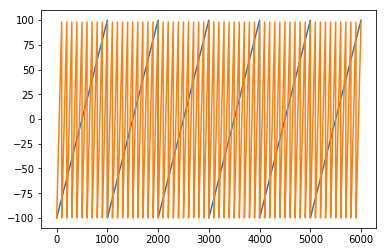

opcodes= 26 ['cst0' 'sign' 'sela' 'selb' 'add' 'sub' 'mult' 'div' 'mod' 'max' 'min'
 'abs' 'log' 'exp' 'sin' 'cos' 'tanh' 'xor' 'shft' 'and' 'or' 'popc'
 'inta' 'intb' 'bit0' 'bitx']
[ 999,0] op=cst0 opA=99.80 opB=98.00 out=   +0.00  ---- A= 63cc B= 6200 O=    0 --- a=       0b1100011 b=       0b1100010 o=                             0b0 
[1999,0] op=sign opA=99.80 opB=98.00 out= +100.00  ---- A= 63cc B= 6200 O= 6400 --- a=       0b1100011 b=       0b1100010 o=                       0b1100100 
[2999,0] op=sela opA=99.80 opB=98.00 out=  +99.80  ---- A= 63cc B= 6200 O= 63cc --- a=       0b1100011 b=       0b1100010 o=                       0b1100011 
[3999,0] op=selb opA=99.80 opB=98.00 out=  +98.00  ---- A= 63cc B= 6200 O= 6200 --- a=       0b1100011 b=       0b1100010 o=                       0b1100010 
[4999,0] op= add opA=99.80 opB=98.00 out= +197.80  ---- A= 63cc B= 6200 O= c5cc --- a=       0b1100011 b=       0b1100010 o=                      0b11000101 
[5999,0] op= sub opA=99.80 

In [5]:
#make the ops
#x=np.vstack((np.random.rand(1000,10),-np.random.rand(1000,10)))
#y=np.vstack((np.ones((1000,1)),np.zeros((1000,1))))

scale = 200
offset = 100

nsamp=26000
x=np.random.random((nsamp,1,28))
y=np.zeros((nsamp,1))



op = np.zeros(nsamp,int)
op  = op.astype(str)
opcodes  = np.zeros(26)
opcodes  = op.astype(str)
opcode=0

# initialize initial data
for i in range(int(nsamp/1000)) :
  for j in range (10) :
    for k in range(100) :
      x[i*1000+j*100+k,0,0]=(j/10+k/1000 )*scale-offset
      x[i*1000+j*100+k,0,1]=(k*1/100     )*scale-offset
  
print(x.shape, y.shape)
plt.plot(x [20000:26000,0,0:2],'-')
#plt.plot(y [0:nsamp], '-')
#plt.plot(yo[0:nsamp], '-')
plt.show()

  


def bit_count(n):
#   assert n >= 0, 'Argument of bit_count() must be non-negative'
    count = 0
    while n:
        n &= n - 1
        count += 1
    return count
  
i=0;

if(1) :
  # cst0
  n=1000 
  x[ i:i+n,:,2:28] =  to_categorical(opcode, 26)
  y[ i:i+n,:     ] = 0
  op[i:i+n]='cst0'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1
  
  # sign 
  n=1000
  x[ i:i+n,:,2:28] = to_categorical(opcode, 26)
  y[ i:i+n,:     ] = np.sign(x[i:i+n,:,0]  )*100
  op[i:i+n]='sign'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1
  


if(1) :
  # sela
  n=1000
  x[ i:i+n,:,2:28] = to_categorical(opcode, 26)
  y[ i:i+n,:     ] = x[ i:i+n,:,0]
  op[i:i+n]='sela'
  opcodes[opcode]=op[i]
  i=i+n; opcode=opcode+1
  
  #selb 
  n=1000
  x[ i:i+n,:,2:28] = to_categorical(opcode, 26)
  y[ i:i+n,:     ] = x[ i:i+n,:,1]
  op[i:i+n]='selb'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1

if(1) :

  # add 
  n=1000 
  x[ i:i+n,:,2:28] = to_categorical(opcode, 26)
  y[ i:i+n,:     ] = x[i:i+n,:,0] + x[i:i+n,:,1] 
  op[i:i+n]='add'
  opcodes[opcode]=op[i]
  i=i+n; opcode=opcode+1
  
if(1)  :
  # sub 
  n=1000
  x[ i:i+n,:,2:28] = to_categorical(opcode, 26)
  y[ i:i+n,:     ] = x[i:i+n,:,0] - x[i:i+n,:,1] 
  op[i:i+n]='sub'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1

if(1) :
  # mult 
  n=1000
  x[ i:i+n,:,2:28] = to_categorical(opcode, 26)
  y[ i:i+n,:     ] = x[i:i+n,:,0] * x[i:i+n,:,1] / 100
  op[i:i+n]='mult'
  opcodes[opcode]=op[i]
  i=i+n; opcode=opcode+1

if(1) :  
  # div 
  n=1000 
  x[ i:i+n,:,2:28] = to_categorical(opcode, 26)
  for j in range(n):
    if x[i+j,:,1]!=0 :
      y[ i+j,0     ] = x[i+j,0,0] / x[i+j,0,1]
    else :
      y[ i+j,0     ] = 0
  op[i:i+n]='div'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1
  
  # mod 
  n=1000 
  x[ i:i+n,:,2:28] = to_categorical(opcode, 26)
  for j in range(n):
    if x[i+j,:,1]!=0 :
      y[ i+j,0     ] = x[i+j,0,0] % x[i+j,0,1]
    else :
      y[ i+j,0     ] = 0
  op[i:i+n]='mod'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1

if (1) :
  # max 
  n=1000
  x[ i:i+n,:,2:28] = to_categorical(opcode, 26)
  y[ i:i+n,:     ] = np.maximum( x[i:i+n,:,0] ,  x[i:i+n,:,1] )
  op[i:i+n]='max'
  opcodes[opcode]=op[i]
  i=i+n; opcode=opcode+1
  
  # min 
  n=1000
  x[ i:i+n,:,2:28] = to_categorical(opcode, 26)
  y[ i:i+n,:     ] = np.minimum(x[i:i+n,:,0] ,  x[i:i+n,:,1] )
  op[i:i+n]='min'
  opcodes[opcode]=op[i]
  i=i+n; opcode=opcode+1
  
  
  # abs 
  n=1000
  x[ i:i+n,:,2:28] = to_categorical(opcode, 26)
  y[ i:i+n,:     ] = np.abs(x[i:i+n,:,0]  )
  op[i:i+n]='abs'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1

if(1):
  # log 
  n=1000
  x[ i:i+n,:,2:28] = to_categorical(opcode, 26)
  for j in range(n):
    if x[i+j,0,0]>0 :
      y[ i+j,0     ] = min(200,np.log(x[i+j,0,0] )*50)
    else :
      y[ i+j,0     ] = 0
  

  op[i:i+n]='log'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1

  # e^x 
  n=1000
  x[ i:i+n,:,2:28] = to_categorical(opcode, 26)
  for j in range(n):
    y[ i+j,0     ]= min(200,np.exp(x[i+j,0,0]/100 )*50 )
  op[i:i+n]='exp'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1
  
  # sin 
  n=1000
  x[ i:i+n,:,2:28] = to_categorical(opcode, 26)
  y[ i:i+n,:     ] = np.sin(x[i:i+n,:,0]/scale*3.14*4 )*100
  op[i:i+n]='sin'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1
  
  # cos 
  n=1000
  x[ i:i+n,:,2:28] = to_categorical(opcode, 26)
  y[ i:i+n,:     ] = np.cos(x[i:i+n,:,0]/scale*3.14*4 )*100
  op[i:i+n]='cos'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1
  
  # tanh 
  n=1000
  x[ i:i+n,:,2:28] = to_categorical(opcode, 26)
  y[ i:i+n,:     ] = np.tanh(x[i:i+n,:,0]/scale*3.14*4)*100
  op[i:i+n]='tanh'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1

if(1) :
   # xor
  n=1000
  x[ i:i+n,:,2:28] = to_categorical(opcode, 26)
  for j in range(n):
    y[ i+j,0     ] = (np.int(x[i+j,:,0]) ^ np.int(x[i+j,:,1])  )
  op[i:i+n]='xor'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1

  # shift 
  n=1000 
  x[ i:i+n,:,2:28] = to_categorical(opcode, 26)
  for j in range(n):
    y[ i+j,0     ] = (np.int(x[i+j,:,0]) << max(0,min(4,np.int(x[i+j,:,1]/25) )) )
  op[i:i+n]='shft'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1

  # and
  n=1000
  x[ i:i+n,:,2:28] = to_categorical(opcode, 26)
  for j in range(n):
    y[ i+j,0     ] = (np.int(x[i+j,:,0]) & np.int(x[i+j,:,1])  )
  op[i:i+n]='and'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1
  
  
  # or
  n=1000
  x[ i:i+n,:,2:28] =to_categorical(opcode, 26)
  for j in range(n):
    y[ i+j,0     ] = (np.int(x[i+j,:,0]) | np.int(x[i+j,:,1])  )
  op[i:i+n]='or'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1
  
  
   
  
  
  # bitcount
  
  n=1000
  x[ i:i+n,:,2:28] = to_categorical(opcode, 26)
  for j in range(n):
    y[ i+j,0     ] = bit_count(max(0,np.int(x[i+j,:,0]))) * 8
  op[i:i+n]='popc'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1

  # inta 
  n=1000
  x[ i:i+n,:,2:28] = to_categorical(opcode, 26)
  for j in range(n):
    y[ i+j,0     ] = (np.int(x[i+j,:,0])) 
  op[i:i+n]='inta'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1

  # intb 
  n=1000
  x[ i:i+n,:,2:28] = to_categorical(opcode, 26)
  for j in range(n):
    y[ i+j,0     ] = (np.int(x[i+j,:,1])) 
  op[i:i+n]='intb'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1

  
  # bit 0
  n=1000
  x[ i:i+n,:,2:28] = to_categorical(opcode, 26)
  for j in range(n):
    
    y[ i+j,0     ] = ((np.int(x[i+j,:,0])) & 1)*100
  op[i:i+n]='bit0'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1

   # bit extract
  n=1000
  x[ i:i+n,:,2:28] = to_categorical(opcode, 26)
  for j in range(n):
    
    y[ i+j,0     ] = ((np.int(x[i+j,:,0]))>>max(0,min(16,np.int(x[i+j,:,1]/25))) & 1)*100
  op[i:i+n]='bitx'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1


print("opcodes=", opcode, opcodes[0:opcode])

xcat0= to_categorical(x[:,0,0],100)
xcat1= to_categorical(x[:,0,1],100)

#xcat0= np.zeros((nsamp,100))
#xcat1= np.zeros((nsamp,100))

model='alu1'

for ii  in range (0,nsamp,int(nsamp/26)) :
  for t in range (1) :   
    i=ii+999 
    printf('[%4d,%d] op=%4s opA=%2.2f opB=%2.2f out=%+8.2f  ---- A=%5x B=%5x O=%5x --- a=%16s b=%16s o=%32s \n', i, t, op[i], x[i,t,0], x[i,t,1], y[i], int(x[i,t,0]*256), int(x[i,t,1]*256), int(y[i]*256) , bin(int(x[i,t,0])), bin(int(x[i,t,1])), bin(int(y[i])))
 


##Make some experimental models

In [6]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras import layers
from keras.datasets import mnist
from keras import backend as K


class sinlayer(layers.Layer):


    def compute_output_shape(self, input_shape):
        shape = list(input_shape)
        assert len(shape) == 2  # only valid for 2D tensors
        shape[-1] *= 3
        return tuple(shape)

    def call(self, inputs):
        #inputs -= K.mean(inputs, axis=1, keepdims=True)
        #inputs = K.l2_normalize(inputs, axis=1)
        pos = inputs
        sin = K.sin(inputs)
        cos = K.cos(inputs)
        return K.concatenate([pos, sin, cos], axis=1)

# global parameters
batch_size = 128
num_classes = 10
epochs = 40

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# build the model
model = Sequential()
model.add(layers.Dense(256, input_shape=(784,)))
model.add(sinlayer())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256))
model.add(sinlayer())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# train the model
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

# next, compare with an equivalent network
# with2x bigger Dense layers and ReLU

11493376/11490434 [==============================] - 17s 2us/step


W0617 16:39:21.382403 139827437365120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0617 16:39:21.385495 139827437365120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0617 16:39:21.393036 139827437365120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0617 16:39:21.409546 139827437365120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0617 16:39:21.419050 

60000 train samples
10000 test samples


W0617 16:39:21.606969 139827437365120 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 5s 77us/step - loss: 0.3831 - acc: 0.8883 - val_loss: 0.1449 - val_acc: 0.9565
Epoch 2/40
28288/60000 [=============>................] - ETA: 0s - loss: 0.1471 - acc: 0.9529

KeyboardInterrupt: ignored

In [7]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras import layers
from keras.datasets import mnist
from keras import backend as K
from keras.layers import Concatenate


class clip10layer(layers.Layer):

  def compute_output_shape(self, input_shape):
    shape = list(input_shape)
    assert len(shape) == 2  # only valid for 2D tensors
    shape[-1] *= 11
    return tuple(shape)
  
  def call(self, inputs):
  #        inputs -= K.mean(inputs, axis=1, keepdims=True)
  #        inputs = K.l2_normalize(inputs, axis=1)
    print('inputs', inputs)
    pos = K.relu(inputs)
    clip0 = K.clip(inputs, 0,10)
    clip1 = K.clip(inputs, 10,20)
    clip2 = K.clip(inputs, 20,30)
    clip3 = K.clip(inputs, 30,40)
    clip4 = K.clip(inputs, 40,50)
    clip5 = K.clip(inputs, 50,60)
    clip6 = K.clip(inputs, 60,70)
    clip7 = K.clip(inputs, 70,80)
    clip8 = K.clip(inputs, 80,90)
    clip9 = K.clip(inputs, 90,100)
    
    return K.concatenate([pos, clip0,clip1,clip2,clip3,clip4,clip5,clip6,clip7,clip8,clip9 ], axis=1)

# global parameters
batch_size = 128
num_classes = 10
epochs = 40

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# build the model


clipmodel=Sequential()
#alumodel.add(Dense(units=64, input_shape=(10,),activation='relu'))


xi    = keras.layers.Input(shape=(784,))
x0    = keras.layers.Dense(  1, activation='relu')(xi)
x1    = keras.layers.Dense(128, activation='relu')(xi)
xclip = clip10layer()(x0)
x2    = keras.layers.Concatenate()([x1, xclip])
x3    = keras.layers.Dense(128, activation='relu')(x2)

#clipmodel.add(layers.Dense(num_classes))
#clipmodel.add(layers.Activation('softmax'))

xout = keras.layers.Dense(num_classes, activation='softmax')(x3)

clipmodel = keras.models.Model(inputs=[xi], outputs=xout )


#
#model = Sequential()
#model.add(layers.Dense(256, input_shape=(784,)))
#model.add(layers.Dense(1))
#model.add(clip10layer())
#model.add(layers.Dropout(0.1))
#model.add(layers.Dense(256))
#model.add(layers.Dense(num_classes))
#model.add(layers.Activation('softmax'))


# compile the model
clipmodel.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

clipmodel.summary()
keras.utils.plot_model(clipmodel, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB')

# train the model
clipmodel.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))


# next, compare with an equivalent network
# with2x bigger Dense layers and ReLU



60000 train samples
10000 test samples
inputs Tensor("dense_4/Relu:0", shape=(?, 1), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1)            785         input_1[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 128)          100480      input_1[0][0]                    
__________________________________________________________________________________________________
clip10layer_1 (clip10layer)     (None, 11)           0           dense_4[0][0]                    
_________

KeyboardInterrupt: ignored

In [8]:

opt = keras.optimizers.adam(lr=0.01, decay=1e-6)




alumodel=Sequential()
#alumodel.add(Dense(units=64, input_shape=(10,),activation='relu'))


xi0 = keras.layers.Input(shape=(228,))
x0 = keras.layers.Dense(128, activation='relu')(xi0)
x00 = keras.layers.Dense(128, activation='relu')(x0)
x01 = keras.layers.Dense(128, activation='linear')(x00)

xi1 = keras.layers.Input(shape=(228,))
x1  = keras.layers.Dense(128, activation='relu')(xi1)
x10 = keras.layers.Dense(128, activation='relu')(x1)
x11 = keras.layers.Dense(1  , activation='relu')(x1)
xsin  = sinlayer()(x10)
xclip = clip10layer()(x11)
x12    = keras.layers.Concatenate()([x1, xsin, xclip])






x10 = keras.layers.Dense(128, activation='linear')(x12)

#xmult = keras.layers.multiply([x00, x10])
xmult = keras.layers.multiply([x00, x10])
#xm0   = keras.layers.add([x00, x10])

xm0  = keras.layers.Dense(128, activation='relu')(xmult)
xm1  = keras.layers.Dense(128, activation='relu')(xm0)
xadd = keras.layers.add([xm1, x0])
xout = keras.layers.Dense(1, activation='linear')(xadd)

alumodel = keras.models.Model(inputs=[xi0, xi1], outputs=xout )
alumodel.compile(loss='mean_absolute_error',optimizer=opt,metrics=['mean_absolute_error'])
alumodel.summary()

keras.utils.plot_model(alumodel, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB')

inputs Tensor("dense_13/Relu:0", shape=(?, 1), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 228)          0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 128)          29312       input_3[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 128)          16512       dense_11[0][0]                   
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 1)            129         dense_11[0][0]                   
_______________________________________________

##Make the models for testing

In [9]:
# alu0 2layer x 100 minimal model 8%
opt = keras.optimizers.adam(lr=0.01, decay=1e-6)

alu0_model=Sequential()
#alumodel.add(Dense(units=64, input_shape=(10,),activation='relu'))


xi   = keras.layers.Input(shape=(228,))
x0   = keras.layers.Dense(100, activation='relu'  )( xi)
xout = keras.layers.Dense(  1, activation='linear')( x0)

alu0_model = keras.models.Model(inputs=xi, outputs=xout )
alu0_model.compile(loss='mean_absolute_error',optimizer=opt,metrics=['mean_absolute_error'])
alu0_model.summary()

keras.utils.plot_model(alu0_model, to_file='alu0_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 228)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               22900     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 101       
Total params: 23,001
Trainable params: 23,001
Non-trainable params: 0
_________________________________________________________________


In [10]:
# alu1 4layer x 100 minimal model
opt = keras.optimizers.adam(lr=0.01, decay=1e-6)

alu1_model=Sequential()
#alumodel.add(Dense(units=64, input_shape=(10,),activation='relu'))


xi   = keras.layers.Input(shape=(228,))
x0   = keras.layers.Dense(100, activation='relu'  )(xi)
x1   = keras.layers.Dense(100, activation='relu'  )(x0)
x2   = keras.layers.Dense(100, activation='relu'  )(x1)
xout = keras.layers.Dense(  1, activation='linear')(x2)

alu1_model = keras.models.Model(inputs= xi, outputs=xout )
alu1_model.compile(loss='mean_absolute_error',optimizer=opt,metrics=['mean_absolute_error'])
alu1_model.summary()

keras.utils.plot_model(alu1_model, to_file='alu1_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 228)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 100)               22900     
_________________________________________________________________
dense_21 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 101       
Total params: 43,201
Trainable params: 43,201
Non-trainable params: 0
_________________________________________________________________


In [11]:
# alu2 2layer x 200 minimal model
opt = keras.optimizers.adam(lr=0.01, decay=1e-6)

alu2_model=Sequential()
#alumodel.add(Dense(units=64, input_shape=(10,),activation='relu'))


xi   = keras.layers.Input(shape=(228,))
x0   = keras.layers.Dense(200, activation='relu'  )( xi)
xout = keras.layers.Dense(  1, activation='linear')( x0)

alu2_model = keras.models.Model(inputs=xi, outputs=xout )
alu2_model.compile(loss='mean_absolute_error',optimizer=opt,metrics=['mean_absolute_error'])
alu2_model.summary()

keras.utils.plot_model(alu2_model, to_file='alu2_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 228)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 200)               45800     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 201       
Total params: 46,001
Trainable params: 46,001
Non-trainable params: 0
_________________________________________________________________


In [12]:
# alu3 4layer x 200  model
opt = keras.optimizers.adam(lr=0.01, decay=1e-6)

alu3_model=Sequential()
#alumodel.add(Dense(units=64, input_shape=(10,),activation='relu'))


xi   = keras.layers.Input(shape=(228,))
x0   = keras.layers.Dense(200, activation='relu'  )(xi)
x1   = keras.layers.Dense(200, activation='relu'  )(x0)
x2   = keras.layers.Dense(200, activation='relu'  )(x1)
xout = keras.layers.Dense(  1, activation='linear')(x2)

alu3_model = keras.models.Model(inputs=xi, outputs=xout )
alu3_model.compile(loss='mean_absolute_error',optimizer=opt,metrics=['mean_absolute_error'])
alu3_model.summary()

keras.utils.plot_model(alu3_model, to_file='alu3_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 228)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 200)               45800     
_________________________________________________________________
dense_27 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_28 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 201       
Total params: 126,401
Trainable params: 126,401
Non-trainable params: 0
_________________________________________________________________


In [13]:
# alu4 4layer x 200  model with mult

opt = keras.optimizers.adam(lr=0.01, decay=1e-6)

alumodel=Sequential()
#alumodel.add(Dense(units=64, input_shape=(10,),activation='relu'))


xi    = keras.layers.Input(shape=(228,))
x00    = keras.layers.Dense(200, activation='relu')(xi)

x01    = keras.layers.Dense(200, activation='relu')(xi)

xmult = keras.layers.multiply([x00, x01])

x2    = keras.layers.Dense(200, activation='relu')(xmult)

x3    = keras.layers.Concatenate()([x00, x01, x2])

x4    = keras.layers.Dense(1, activation='linear')(x3)


xout = keras.layers.Dense(1, activation='linear')(x4)

alu4_model = keras.models.Model(inputs=xi, outputs=xout )
alu4_model.compile(loss='mean_absolute_error',optimizer=opt,metrics=['mean_absolute_error'])
alu4_model.summary()

keras.utils.plot_model(alu4_model, to_file='alu4_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 228)          0                                            
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 200)          45800       input_8[0][0]                    
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 200)          45800       input_8[0][0]                    
__________________________________________________________________________________________________
multiply_2 (Multiply)           (None, 200)          0           dense_30[0][0]                   
                                                                 dense_31[0][0]                   
__________

##Setup the training system

In [26]:
#reset history, create results buffer for up to 1000 eons
eons=0;
maxeons=1000;
yhist=np.zeros((maxeons,nsamp))
#ymodel[0:maxeons]=""
print(yhist.shape)

(1000, 26000)


In [15]:
ymodel = np.array(range(0,maxeons),dtype=object )
print(ymodel.shape, ymodel.dtype)
ymodel[:]='...'
print(ymodel[0])

(1000,) object
...


## Train the various models

In [0]:
from keras.callbacks import LearningRateScheduler

# learning rate schedule
def step_decay(epoch):
  initial_lrate = 0.001
  drop = 0.5
  epochs_drop = 10.0
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  #if epoch < 100: lrate= .001
  #if epoch < 30: lrate= .001
  #if epoch < 20: lrate= .01
  #if epoch < 10: lrate= .001
    
  if((epoch%10)==0): print ( 'Epoch:',epoch,'Learning Rate=',  lrate)
  return lrate

In [0]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import



from matplotlib import pylab
from google.colab import widgets
grid = widgets.Grid(4, 1)

lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

#reshape x and y for training
xx=np.reshape(x,(nsamp,28))
yy=np.reshape(y,(nsamp))
xx0=np.zeros((26000,228))

#print some diags
print('model=',model)
print(x.shape, y.shape)
print(xx.shape, yy.shape)
print(xx0.shape, xx.shape, xcat0.shape,xcat1.shape)
print("eons=",eons)


 
# schedule models and inputs  
for eon in range(100,105) :
  

  if(eon>= 0) : model='alu0'; inp='bin'; #not working yet
  if(eon>=10) : model='alu1'; inp='bin';
  if(eon>=20) : model='alu2'; inp='bin';
  if(eon>=30) : model='alu3'; inp='bin';
  if(eon>=40) : model='alu4'; inp='bin';
  
  if(eon>=50) : model='alu0'; inp='cat';
  if(eon>=60) : model='alu1'; inp='cat';
  if(eon>=70) : model='alu2'; inp='cat';
  if(eon>=80) : model='alu3'; inp='cat';
  if(eon>=90) : model='alu4'; inp='cat';

  if(eon>=100) : model='alu1'; inp='bin';
  if(eon>=120) : model='alu3'; inp='bin';
  if(eon>=140) : model='alu4'; inp='bin';
  if(eon>=160) : model='alu3'; inp='cat';
  if(eon>=180) : model='alu4'; inp='cat';
  

  #select the various inputs 
  if inp=='bin' :
    xcat0= np.zeros((nsamp,100))
    xcat1= np.zeros((nsamp,100))
  if inp=='cat' : 
    xcat0= to_categorical(x[:,0,0],100)
    xcat1= to_categorical(x[:,0,1],100)
  
  xx0=np.concatenate([xx,xcat0,xcat1],axis=1)  
  
  # shuffle the data for fitting
  pindex=np.random.permutation(26000)
  print('yp=',yp.shape,'xp=',xp.shape, 'pindex',pindex.shape)
  
  yp=yy[pindex]
  xp=xx0[pindex,:]

  print('eon=',eon,'model=',model, 'inp=',inp)

  #select model to fit
  if(model=='alu0') : hist=alu0_model.fit(xp, yp, validation_split=0.0, epochs=50, batch_size=32, callbacks=[lrate], verbose=1, shuffle=True)
  if(model=='alu1') : hist=alu1_model.fit(xp, yp, validation_split=0.0, epochs=50, batch_size=32, callbacks=[lrate], verbose=1, shuffle=True)
  if(model=='alu2') : hist=alu2_model.fit(xp, yp, validation_split=0.0, epochs=50, batch_size=32, callbacks=[lrate], verbose=1, shuffle=True)
  if(model=='alu3') : hist=alu3_model.fit(xp, yp, validation_split=0.0, epochs=50, batch_size=32, callbacks=[lrate], verbose=1, shuffle=True)
  if(model=='alu4') : hist=alu4_model.fit(xp, yp, validation_split=0.0, epochs=50, batch_size=32, callbacks=[lrate], verbose=1, shuffle=True)
 
  print(model)

  #evaluate the model 
  if(model=='alu0') : yo=alu0_model.predict(xx0, verbose=1)
  if(model=='alu1') : yo=alu1_model.predict(xx0, verbose=1)
  if(model=='alu2') : yo=alu2_model.predict(xx0, verbose=1)
  if(model=='alu3') : yo=alu3_model.predict(xx0, verbose=1)
  if(model=='alu4') : yo=alu4_model.predict(xx0, verbose=1)
 
  #store the results to yhist
  eons=eons+1;
  yhist[eons,:]=yo[:,0]
  ymodel[eons]=model

  #plot the first opcode data and results
  with grid.output_to(0, 0):
    print('op=',opcodes[0], 'eons=',str(eons))
    plt.plot(x [0:1000,0],'-')
    plt.plot(y [0:1000], '--')
    plt.plot(yo[0:1000], '--')
    plt.show()
  
  #print test examples from each opcode 
  with grid.output_to(3, 0):
    grid.clear_cell()
    printf('\n   o:')
    for i in range(999,nsamp,int(nsamp/26)) :
      printf(' %5s,', op[i] )
    
    printf('\n   a:')
    for i in range(999,nsamp,int(nsamp/26)) :
      printf(' %5.2f,', xx[i,0])
    
    printf('\n   b:')
    for i in range(999,nsamp,int(nsamp/26)) :
      printf(' %5.2f,', xx[i,1])
    
    print()
    printf('\n   y:')
    for i in range(999,nsamp,int(nsamp/26)) :
      printf(' %5.2f,', y[i])
    
    printf('\n  yo:')
    for i in range(999,nsamp,int(nsamp/26)) :
      printf(' %5.2f,', yo[i])
    
    printf('\n err:')
    for i in range(999,nsamp,int(nsamp/26)) :
      printf(' %5.2f,', yo[i]- y[i])
    
    printf('\nperr:')
    for i in range(999,nsamp,int(nsamp/26)) :
      printf(' %5.2f,', (yo[i]- y[i]) / max(.001,y[i]))
      
    print('\n')
    
    print(hist.history.keys())
    print(hist.history['mean_absolute_error'])
 
  #plot the accuracy and learning rate
  with grid.output_to(1, 0):
    print('eons=',eons)

    # summarize history for accuracy
    plt.plot(hist.history['mean_absolute_error'])
    #plt.plot(hist.history['mean_squared_error'])
    #plt.plot(hist.history['val_mean_squared_error'])
    plt.plot(hist.history['lr'])
    plt.title('model='+ ymodel[eons]+'  accuracy eons='+ str(eons))
    plt.ylabel('mean_absolute_error')
    plt.xlabel('epoch')
    plt.legend(['mse', 'lr'], loc='upper left')
    plt.grid(True)
    plt.show()

#some results
#-------------------------
#alu0 cat e=10 err=  5.0 
#alu1 cat e=10 err=  0.5 
#alu2 cat e=10 err=  3.0 
#alu3 cat e=10 err=  0.2 
#alu4 cat e=10 err=  0.25 
#alu0 bin e=10 err= 10.5 
#alu1 bin e=10 err=  4.5 
#alu2 bin e=10 err=  9.0 
#alu3 bin e=10 err=  3.8 
#alu4 bin e=10 err=  3.0 


model= alu4
(26000, 1, 28) (26000, 1)
(26000, 28) (26000,)
(26000, 228) (26000, 28) (26000, 100) (26000, 100)
eons= 5
yp= (26000,) xp= (26000, 228) pindex (26000,)
eon= 100 model= alu1 inp= bin
Epoch 1/50
Epoch: 0 Learning Rate= 0.001
26000/26000 [==============================] - 3s 112us/step - loss: 5.6762 - mean_absolute_error: 5.6762
Epoch 2/50
26000/26000 [==============================] - 3s 112us/step - loss: 5.7605 - mean_absolute_error: 5.7605
Epoch 3/50
26000/26000 [==============================] - 3s 113us/step - loss: 5.7757 - mean_absolute_error: 5.7757
Epoch 4/50
26000/26000 [==============================] - 3s 112us/step - loss: 5.7676 - mean_absolute_error: 5.7676
Epoch 5/50
26000/26000 [==============================] - 3s 114us/step - loss: 5.7986 - mean_absolute_error: 5.7986
Epoch 6/50
 3360/26000 [==>...........................] - ETA: 2s - loss: 6.3291 - mean_absolute_error: 6.3291

##Make a set of charts for the opcodes

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

26000/26000 [==============================] - 1s 31us/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


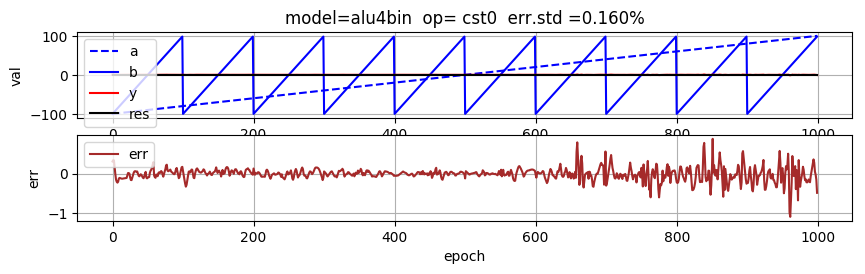

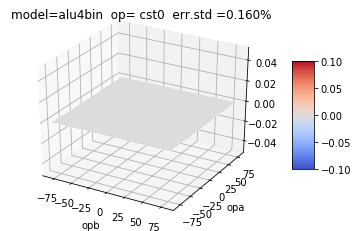

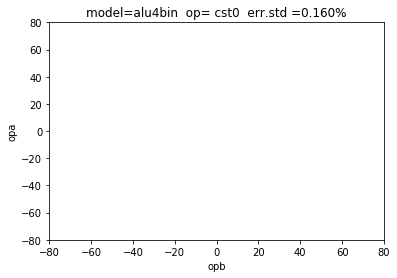

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

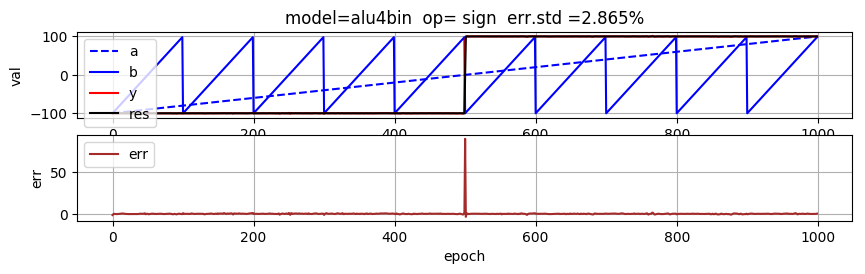

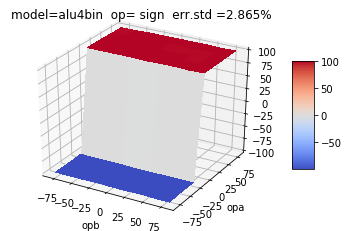

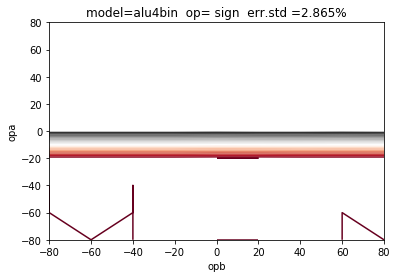

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

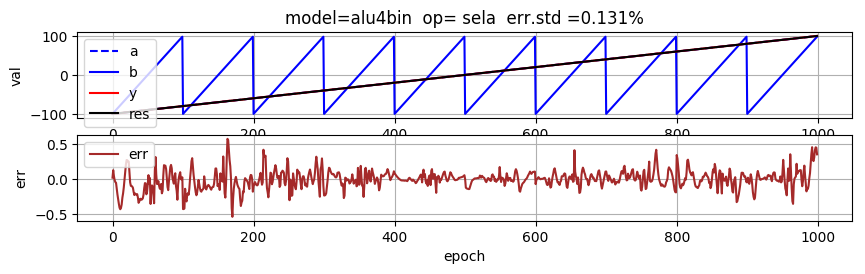

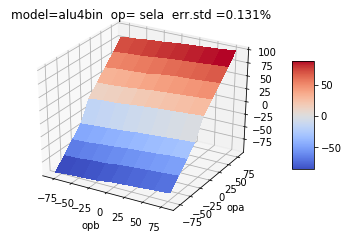

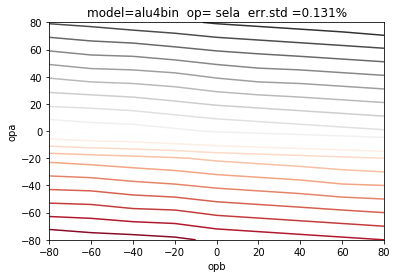

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

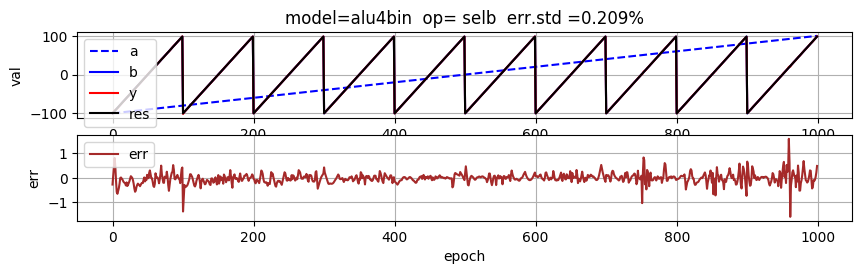

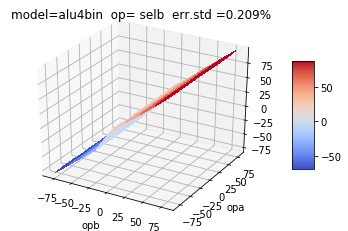

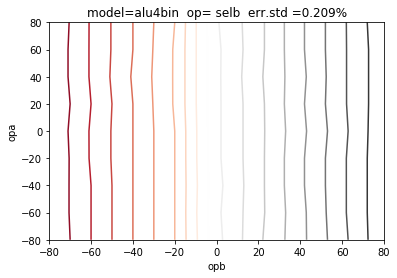

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

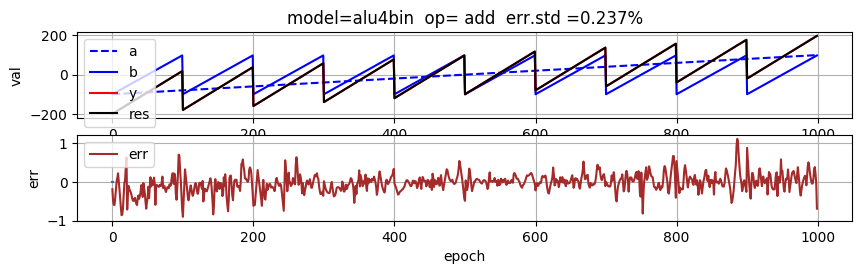

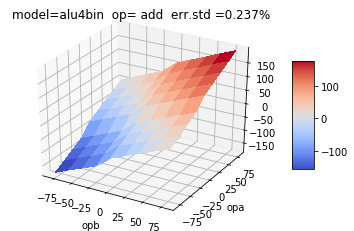

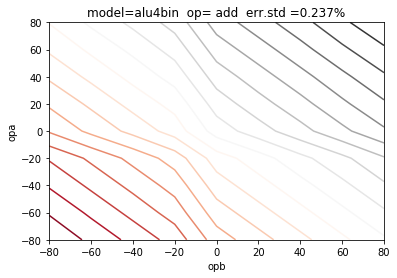

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

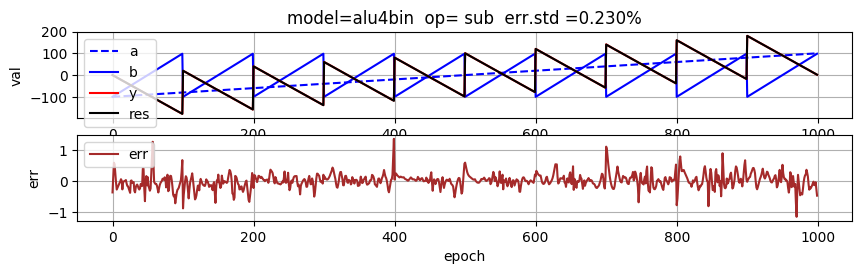

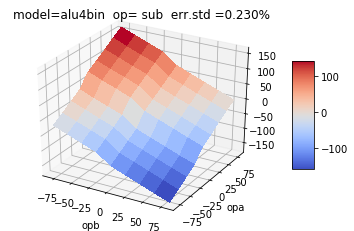

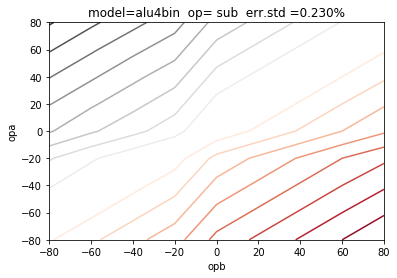

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

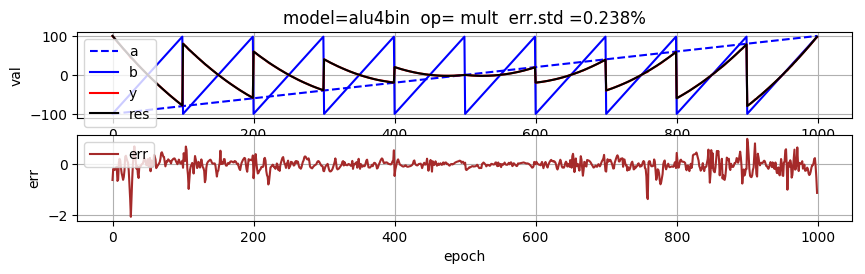

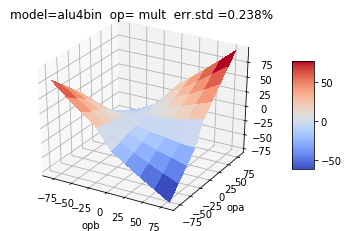

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

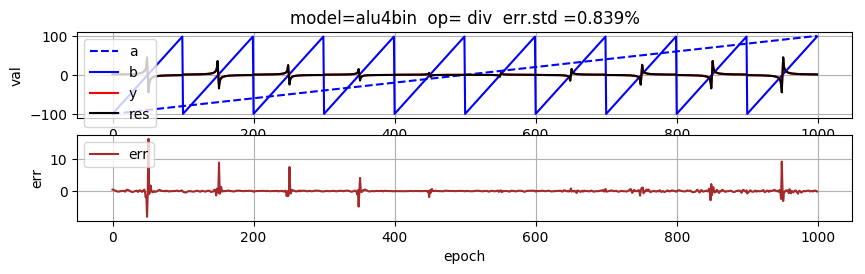

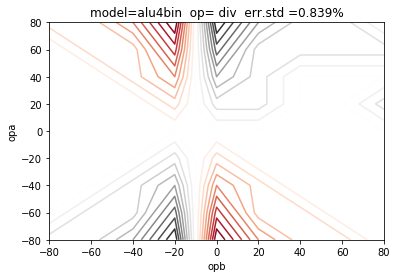

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

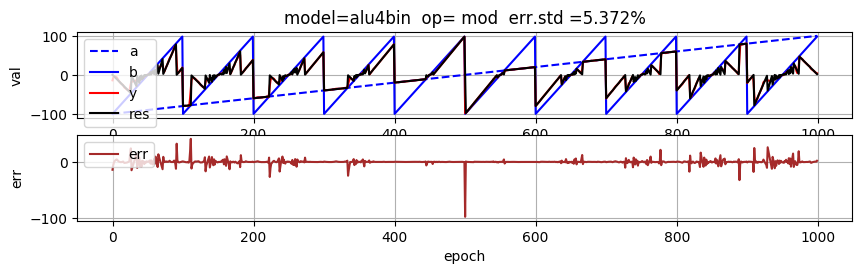

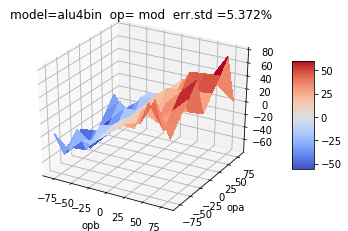

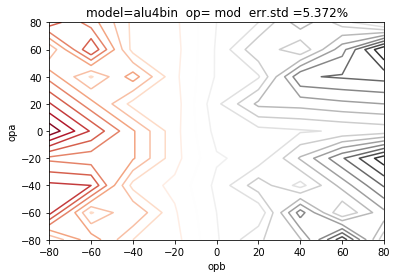

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

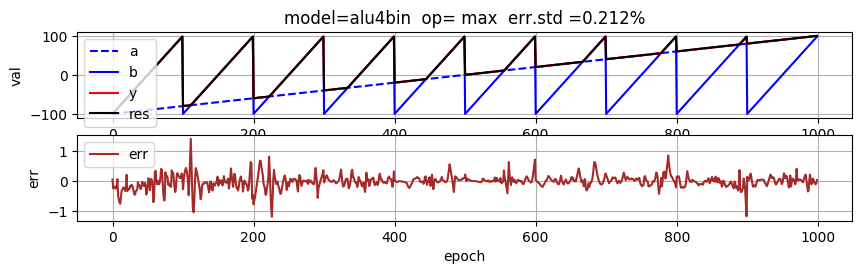

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

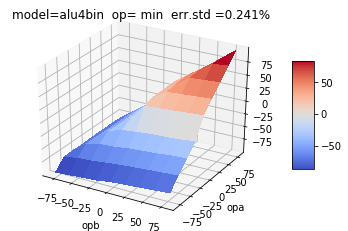

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

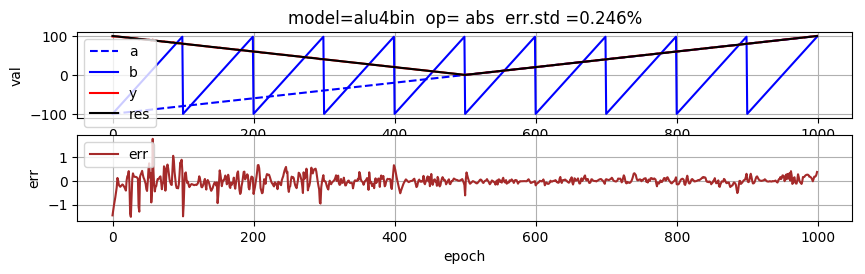

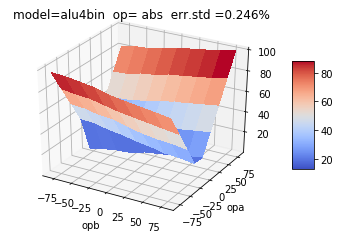

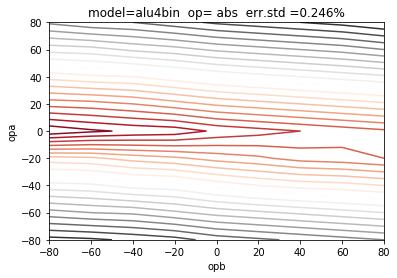

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

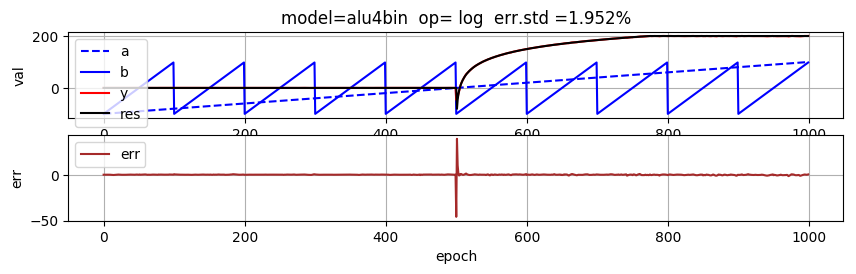

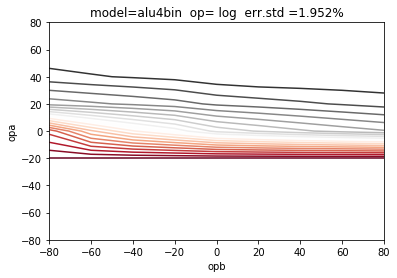

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

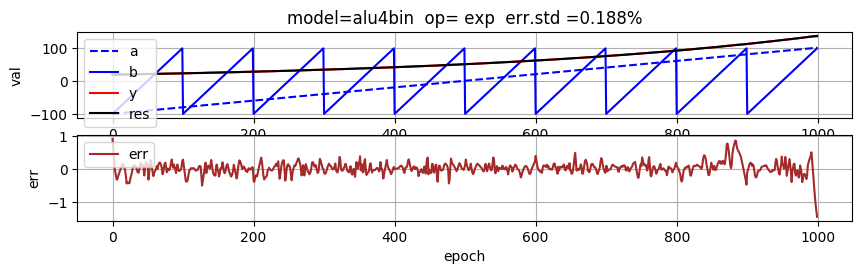

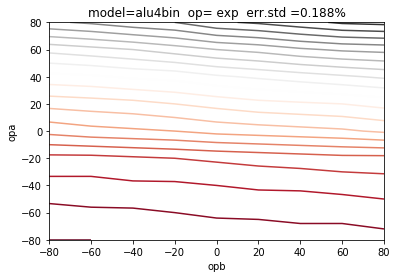

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

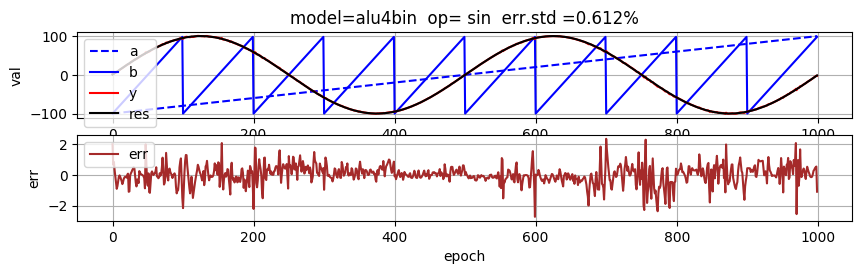

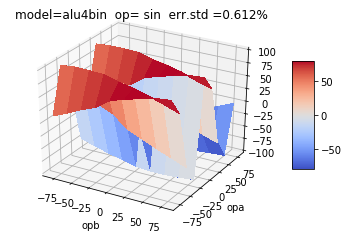

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

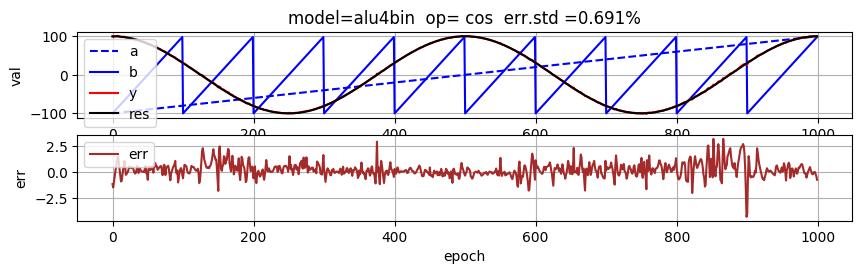

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

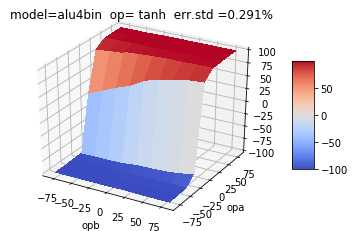

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

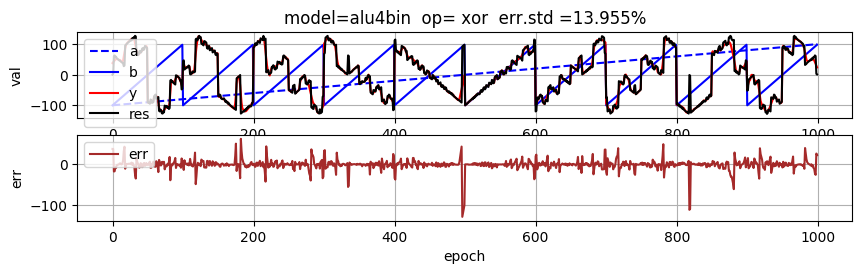

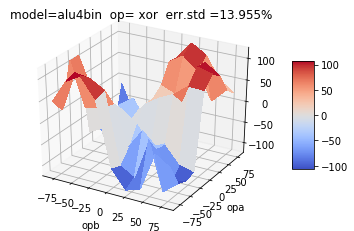

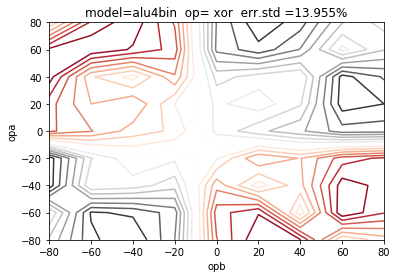

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

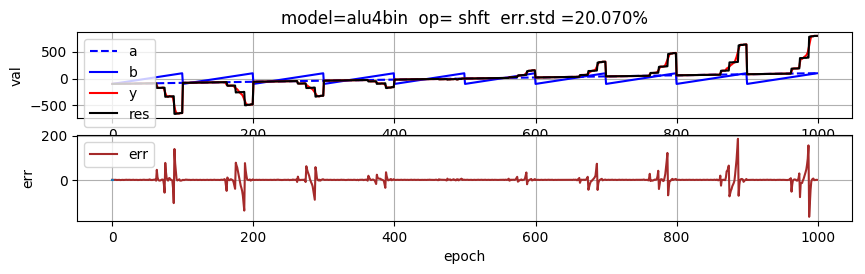

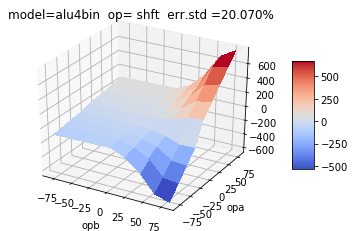

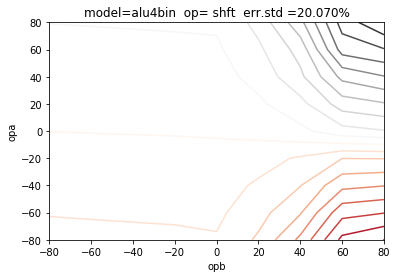

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

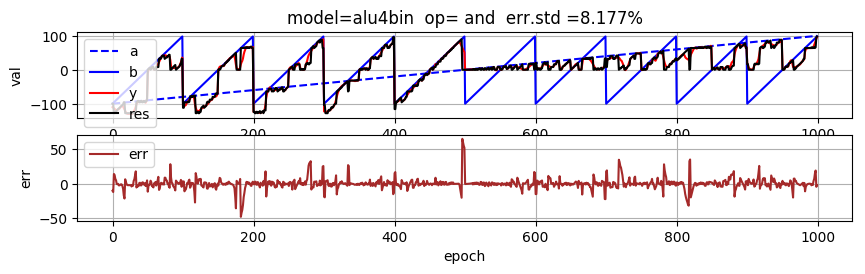

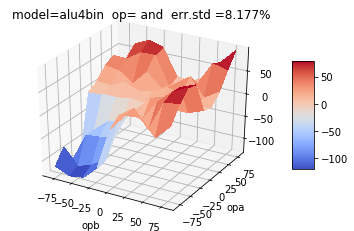

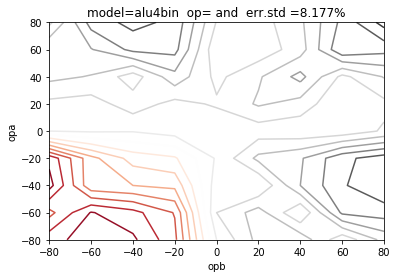

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

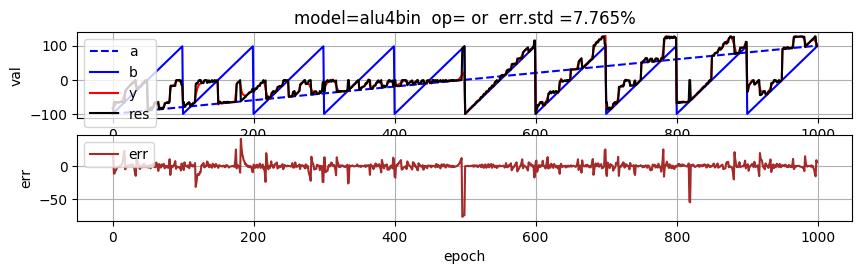

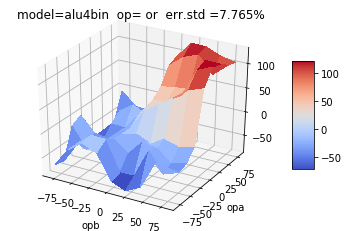

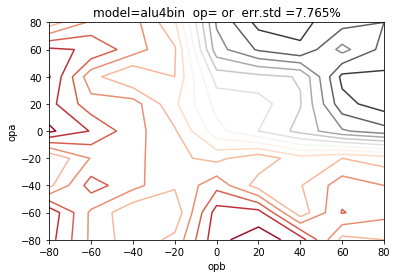

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

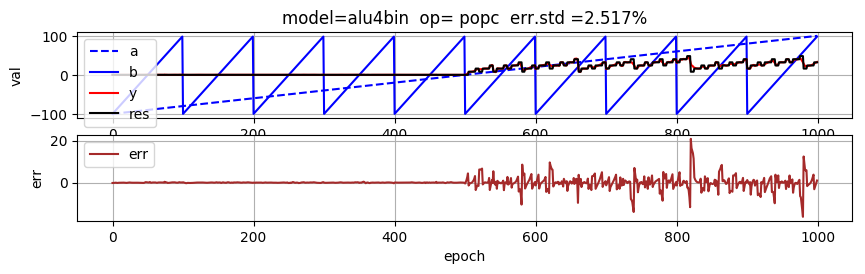

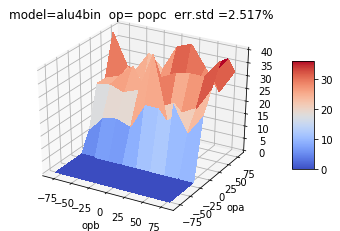

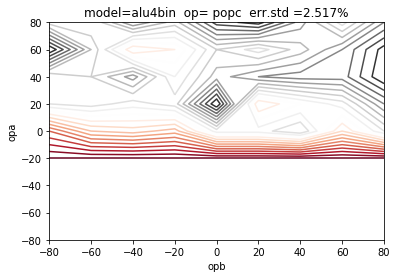

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

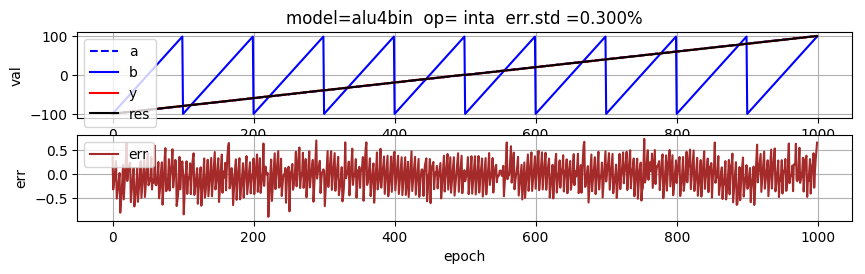

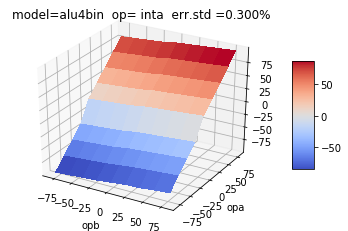

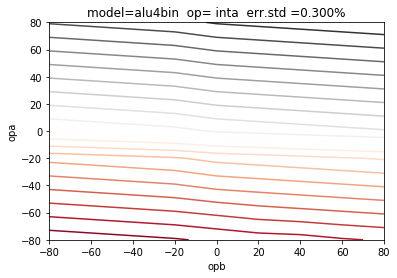

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

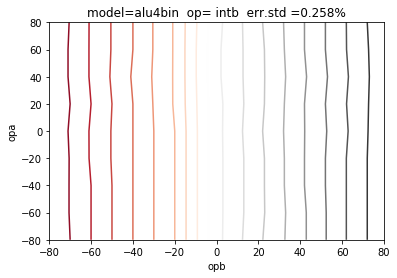

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

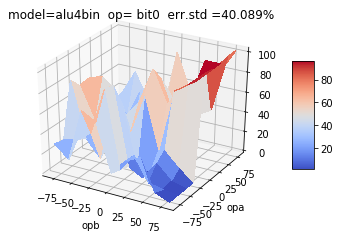

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

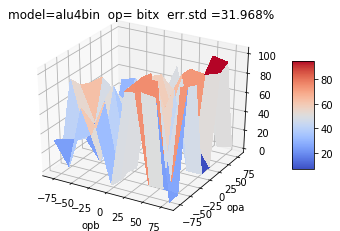

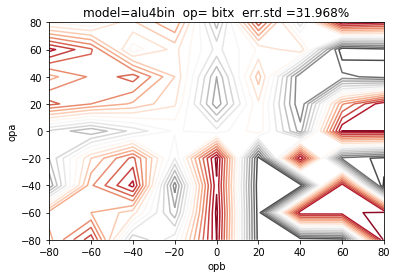

<IPython.core.display.Javascript object>

In [24]:


from matplotlib import pylab
from google.colab import widgets
tb = widgets.TabBar([str(opcodes[p]) for p in range(26)])

#for i in range(26):
#  # Only select the first 3 tabs, and render others in the background.
#  with tb.output_to(i, select=(i < 3)):
#    pylab.plot([1, i, 3])
#    pylab.show()


#yo = alumodel.predict( [xx0,xx0], verbose=1)
#yo = alu0_model.predict( [xx0,xx0], verbose=1)

if(model=='alu0') : yo = alu0_model.predict( xx0, verbose=1)
if(model=='alu1') : yo = alu1_model.predict( xx0, verbose=1)
if(model=='alu2') : yo = alu2_model.predict( xx0, verbose=1)
if(model=='alu3') : yo = alu3_model.predict( xx0, verbose=1)
if(model=='alu4') : yo = alu4_model.predict( xx0, verbose=1)



err=yo-y

for p in range(0,26) :
 
  i=p*1000
  #print(i)
  std=np.std(err[i:i+1000])
  #print(std)
  
  dpi = 200
  xinch = 2000 / dpi
  yinch =  500 / dpi
  
  
  with tb.output_to(p,select=p<3) :

    # plot and save in the same size as the original
    fig = plt.figure(figsize=(xinch,yinch),dpi=100)
    
    plt.subplot(2, 1, 1)
  
    plt.plot(x [i:i+1000,0,0],label="a",color='blue',linestyle='--')
    plt.plot(x [i:i+1000,0,1],label="b",color='blue',linestyle='-')
    plt.plot(yo[i:i+1000],    label="res",color='red')
    plt.plot(y [i:i+1000],    label="y",color='black')
   
  
    title= 'model=' + ymodel[eons] + inp + "  op="+' '+ op[i]+'  err.std ='+str('%3.3f%%'% std)
    
    plt.title(title)
    plt.ylabel('val')
    
    plt.legend(['a', 'b', 'y', 'res', 'err'], loc='upper left')
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.ylabel('err')
    plt.xlabel('epoch')
    plt.grid(True)
    
    plt.plot(err[i:i+1000], label="err",color='brown')
    plt.plot([0,0], label="zero")
    plt.legend(['err'], loc='upper left')

   #pylab.show()

  #

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    # Make data.
    XX = np.arange(-100, 100, 20)
    YY = np.arange(-100, 100, 20)
    XX, YY = np.meshgrid(XX, YY)
    ZZ = 0*(XX**2 + YY**2)
    #ZZ = np.sin(RR)
   
    z=np.zeros((10,10))
    #z=ZZ
    
    #print('YY=', YY.shape, YY[0:10,0])
    #print('ZZ=', ZZ.shape, ZZ[0:10,0])
    #print('z=', z.shape, z[0:10,0])
    
     
    for  ii in range(i,i+1000) :
      vara=int(xx[ii,0]/20)
      varb=int(xx[ii,1]/20)
      varo=int(yo[ii])
      #printf('ii=%d vara=%d, varb=%d, varo=%d\n', ii, vara, varb, varo)
      
      #z[vara+10, varb+10]=varo
      ZZ[vara+5, varb+5]=varo
    #print(z[0:10,0:10])
    # Plot the surface.
    surf = ax.plot_surface(XX[1:10,1:10], YY[1:10,1:10], ZZ[1:10,1:10], cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    plt.title(title)
    plt.ylabel('opa')
    plt.xlabel('opb')

    
    
    # Customize the z axis.
    #ax.set_zlim(-1.01, 1.01)
    #ax.zaxis.set_major_locator(LinearLocator(10))
    #ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    
    plt.show()  
    
    fig = plt.figure()
    #ontour = plt.contour(XX, YY, z, colors='black')
    #ontour = plt.contour(XX, YY, z, colors='RdGy')
    contour = plt.contour(XX[1:10,1:10], YY[1:10,1:10], ZZ[1:10,1:10], 20, cmap='RdGy');

    plt.title(title)
    plt.ylabel('opa')
    plt.xlabel('opb')




In [22]:
print(xcat0[1,:])


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


##Make a set of movies to show training history for each opcode

/content/movies
/content
Creation of the directory path
/content/movies
alu0_model.png	ALU_op_bit0.mp4  ALU_op_log.mp4   ALU_op_selb.mp4
alu1_model.png	ALU_op_bitx.mp4  ALU_op_max.mp4   ALU_op_shft.mp4
alu2_model.png	ALU_op_cos.mp4	 ALU_op_min.mp4   ALU_op_sign.mp4
alu3_model.png	ALU_op_cst0.mp4  ALU_op_mod.mp4   ALU_op_sin.mp4
alu4_model.png	ALU_op_div.mp4	 ALU_op_mult.mp4  ALU_op_sub.mp4
ALU_op_abs.mp4	ALU_op_exp.mp4	 ALU_op_or.mp4	  ALU_op_tanh.mp4
ALU_op_add.mp4	ALU_op_inta.mp4  ALU_op_popc.mp4  ALU_op_xor.mp4
ALU_op_and.mp4	ALU_op_intb.mp4  ALU_op_sela.mp4  model.png
(1000, 26000)
(26000, 1) ...


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationW

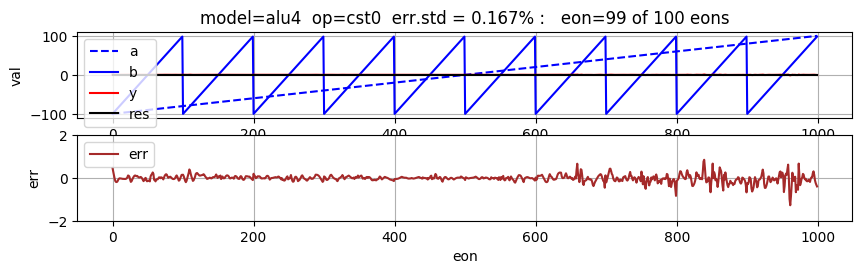

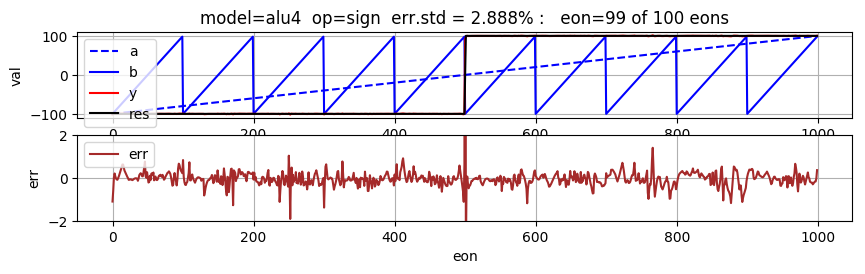

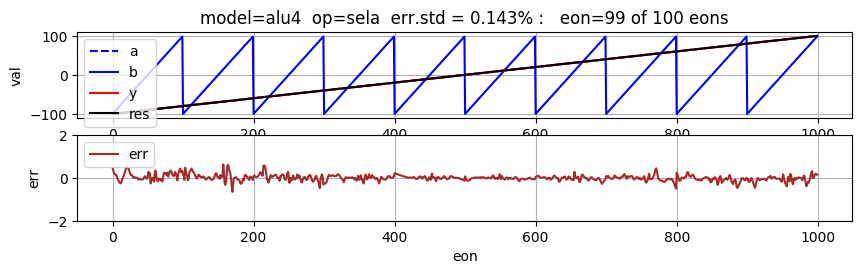

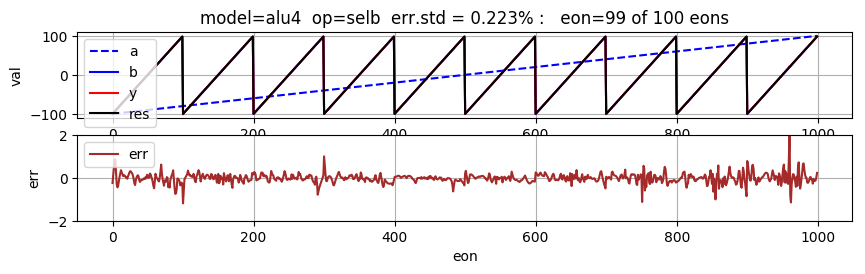

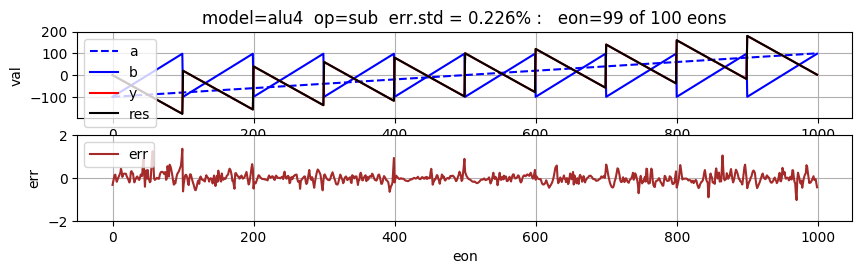

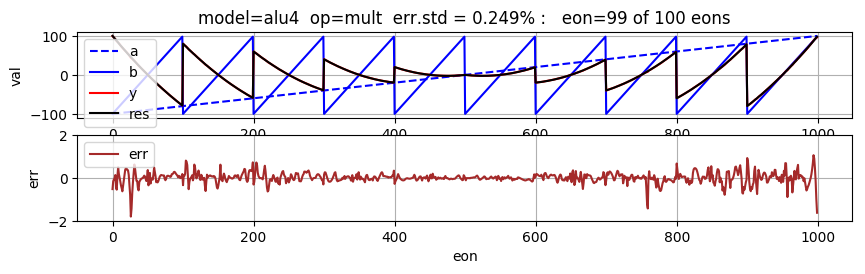

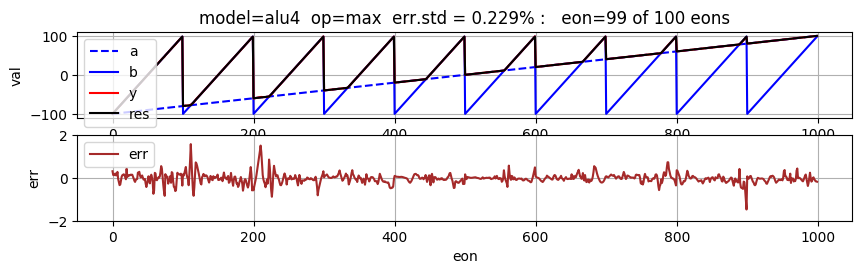

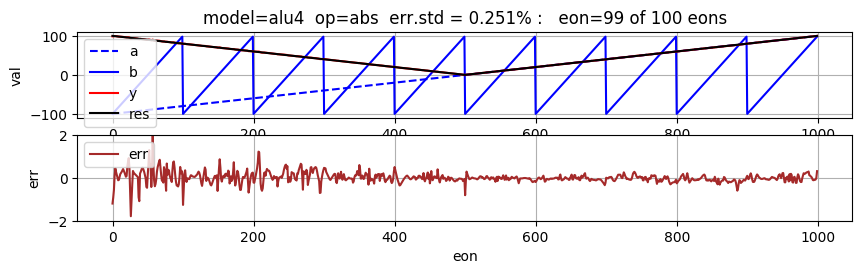

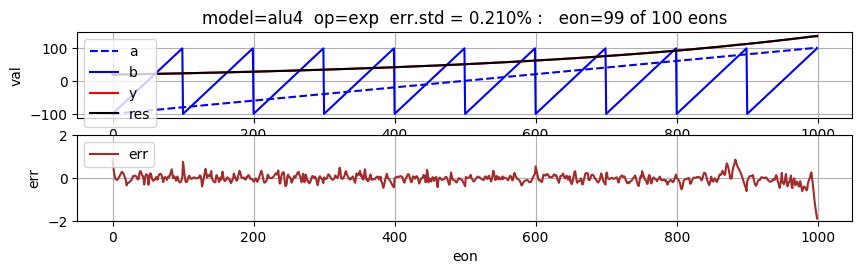

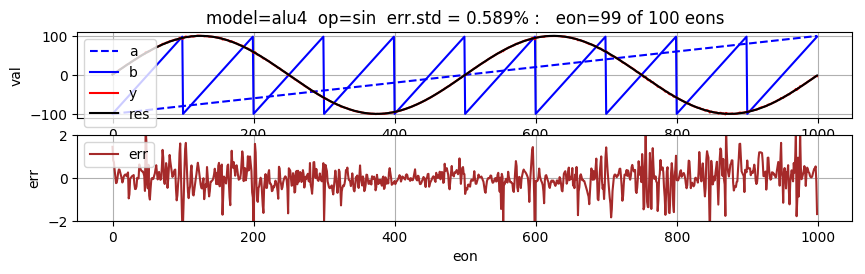

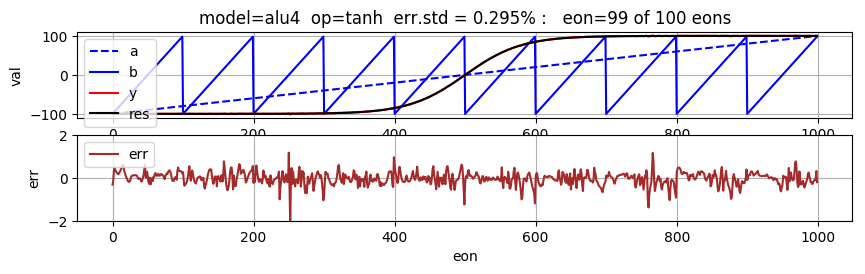

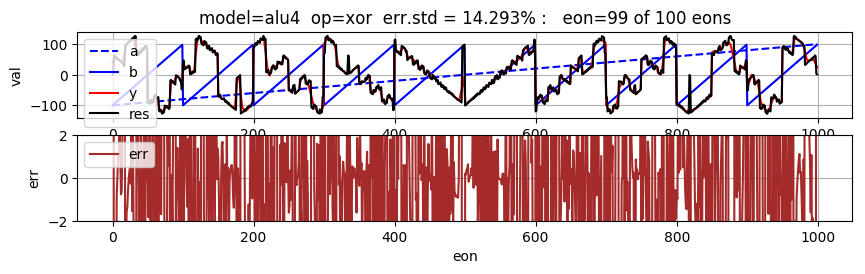

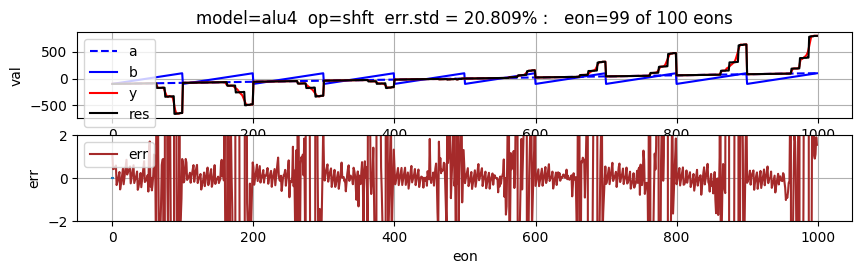

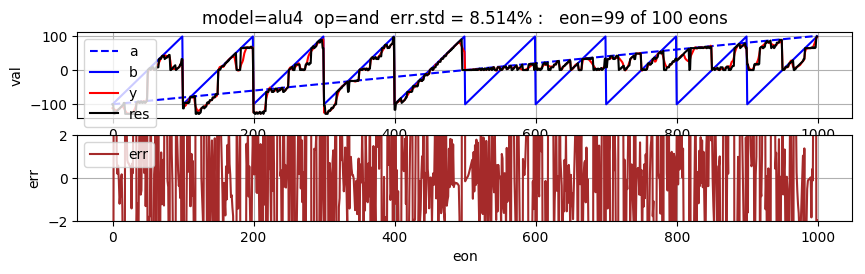

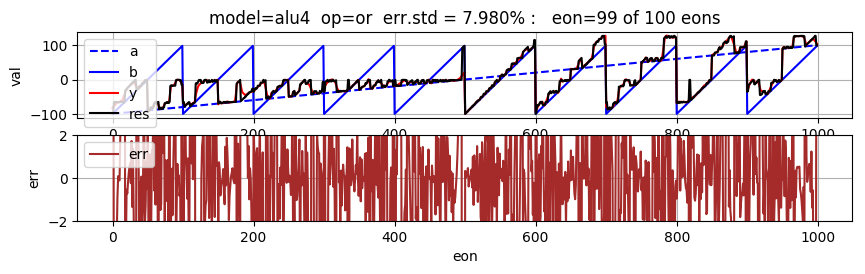

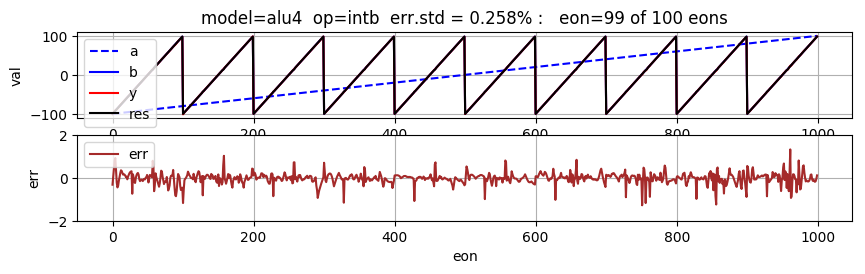

In [25]:
#make a movie 

import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
from matplotlib.animation import FFMpegWriter
from matplotlib.animation import FFMpegFileWriter
from matplotlib.animation import ImageMagickWriter

import base64
from IPython.display import HTML


# Fixing random state for reproducibility
#np.random.seed(19680801)

#make the movie dir and delete any existing movies
import os

print(os.getcwd())
os.chdir('/content')
print(os.getcwd())
try:  
    os.mkdir("./movies")
except OSError:  
    print ("Creation of the directory %s"  % 'path')
else:  
    print ("Successfully created the directory %s " % 'path')
    
os.chdir('./movies')

print(os.getcwd())
!ls
!rm ./*.mp4

fps=eons/10
#fps=10

print(yhist.shape)

#FFMpegWriter = manimation.writers['ffmpeg']
#FFMpegWriter = manimation.writers['ImageMagickWriter']
#FFMpegWriter = manimation.writers['AVConvWriter']

metadata     = dict(title='Movie Test', artist='Matplotlib', comment='Movie support!')
writer       = FFMpegWriter(fps=fps, codec=None, bitrate=None, metadata=metadata)
#writer       = ImageMagickWriter(fps=1, codec=None, bitrate=None, metadata=metadata)

#ImageMagickWriter

dpi = 200.
xinch = 2000 / dpi
yinch =  500 / dpi

#fig = plt.figure(figsize=(xinch,yinch),dpi=100)



print(y.shape,ymodel[0])
#tb = widgets.TabBar([str(opcodes[p]) for p in range(26)])

for p in range (26) :
  
#  with tb.output_to(p,select=p<3) :
  if(1) :

    vtitle='ALU_op_' +  opcodes[p] + '.mp4'
    fig = plt.figure(figsize=(xinch,yinch),dpi=100)
  
    with writer.saving(fig, vtitle, dpi=100):
      #wite 40 frames
      for f in range(eons):
        i=p*1000
        
        #print('make frame p=%d frame=%d',p,f)
        yo=yhist[f, :]
        err=yo[:] - y[:,0]
        std=np.std(err[i:i+1000])
        title= 'model=' + ymodel[f] + '  op=' + op[i]+'  err.std = ' + str('%3.3f%% : '% std)+'  eon=' + str(f)+ ' of '  + str(eons) + ' eons'

        if f==0: 
          # plot 
          #fig = plt.figure(figsize=(xinch,yinch))
     
          plt.subplot(2, 1, 1)
    
          plt.plot(x  [ i:i+1000,0,0],label="a",color='blue',linestyle='--')
          plt.plot(x  [ i:i+1000,0,1],label="b",color='blue',linestyle='-')
          lo,=plt.plot(yo [ i:i+1000],    label="res",color='red')
          plt.plot(y  [ i:i+1000],    label="y",color='black')
          
             
          plt.title(title)
          plt.ylabel('val')
         
          plt.legend(['a', 'b', 'y', 'res', 'err'], loc='upper left')
          plt.grid(True)
      
          plt.subplot(2, 1, 2)
          plt.ylabel('err')
          plt.xlabel('eon')
          plt.grid(True)
          plt.ylim([-2,+2])
          
           
          le,=plt.plot(err[i:i+1000], label="err",color='brown')
          plt.plot([0,0], label="zero")
          plt.legend(['err'], loc='upper left')
     
        else :
          
          lo.set_data(range(1000),yo [ i:i+1000])
          le.set_data(range(1000),err[ i:i+1000])
          
          plt.subplot(2, 1, 1)
          plt.title(title)
          
        plt.show()
        writer.grab_frame()

    video = open('/content/movies/'+vtitle, 'r+b').read()
    
    encoded = base64.b64encode(video)
    HTML(data='''<video alt="test" controls>
                 <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii')))
    
  video = open('/content/movies/ALU_op_cst0.mp4', 'r+b').read()
  encoded = base64.b64encode(video)
  HTML(data='''<video alt="test" controls>
                  <source src="data:video/mp4;base64,{0}" type="video/mp4" />
               </video>'''.format(encoded.decode('ascii')))